# Import libraries

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models,layers
from time import perf_counter
%matplotlib inline
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
tf.compat.v1.set_random_seed(0)
np.random.seed(0)
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.layers import Dense, Flatten, Conv2D, AveragePooling2D,Activation
from keras.layers import BatchNormalization,MaxPooling2D,Dropout
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from glob import glob
import random


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

# Load Data

In [2]:
batch_size = 128
img_height = 224
img_width = 224

In [3]:
#Load training dataset
train_path="/kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/train"
valid_path="/kaggle/input/new-plant-diseases-dataset/new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid"


train_data = tf.keras.preprocessing.image_dataset_from_directory(
   train_path,
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size

)

# loading validation dataset
val_data =  tf.keras.preprocessing.image_dataset_from_directory(
   valid_path ,
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size)





Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [4]:
from tensorflow.keras import layers 
data_preprocess = tf.keras.Sequential(
    name="data_preprocess",
    layers=[ layers.Rescaling(1.0/255),]
)

# Perform Data Processing on the train, val dataset
train_ds = train_data.map(lambda x, y: (data_preprocess(x), y))
val_ds = val_data.map(lambda x, y: (data_preprocess(x), y))


# Total Number of  disease 

In [5]:
class_names = train_data.class_names
print(class_names)
print("\nTotal disease classes are: {}".format(len(class_names)))

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Sp

# Shape of dataset

In [6]:
diseases_train = os.listdir(train_path)
diseases_valid = os.listdir(valid_path)
print("Size of Train Data",len(diseases_train))
print("Size of Test Data",len(diseases_valid))

Size of Train Data 38
Size of Test Data 38


In [7]:
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
val_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [9]:
plants = []
NumberOfDiseases = 0
for plant in class_names:
    if plant.split('___')[0] not in plants:
        plants.append(plant.split('___')[0])
    if plant.split('___')[1] != 'healthy':
        NumberOfDiseases += 1

# Number of Unique Plants

In [10]:
#unique plants name
print("Number of Unique plants:" ,len(plants))
print(f"Unique Plants are: \n{plants}")

Number of Unique plants: 14
Unique Plants are: 
['Apple', 'Blueberry', 'Cherry_(including_sour)', 'Corn_(maize)', 'Grape', 'Orange', 'Peach', 'Pepper,_bell', 'Potato', 'Raspberry', 'Soybean', 'Squash', 'Strawberry', 'Tomato']


# Number of Unique Disease

In [11]:
#Number of unique disease
print("Number of diseases: {}".format(NumberOfDiseases))

Number of diseases: 26


# Number of Image for each disease

In [12]:
# Number of images for each disease 
nums = {}
for disease in class_names:
    nums[disease] = len(os.listdir(train_path + '/' + disease))
    img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

no. of images
Apple___Apple_scab                                           2016
Apple___Black_rot                                            1987
Apple___Cedar_apple_rust                                     1760
Apple___healthy                                              2008
Blueberry___healthy                                          1816
Cherry_(including_sour)___Powdery_mildew                     1683
Cherry_(including_sour)___healthy                            1826
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot           1642
Corn_(maize)___Common_rust_                                  1907
Corn_(maize)___Northern_Leaf_Blight                          1908
Corn_(maize)___healthy                                       1859
Grape___Black_rot                                            1888
Grape___Esca_(Black_Measles)                                 1920
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)                   1722
Grape___healthy                                              1692
Orange___Haunglongbing_(Citrus_greening)                     2010
Peach___Bacterial_spot                                       1838
Peach___healthy                                              1728
Pepper,_bell___Bacterial_spot                                1913
Pepper,_bell___healthy                                       1988
Potato___Early_blight                                        1939
Potato___Late_blight                                         1939
Potato___healthy                                             1824
Raspberry___healthy                                          1781
Soybean___healthy                                            2022
Squash___Powdery_mildew                                      1736
Strawberry___Leaf_scorch                                     1774
Strawberry___healthy                                         1824
Tomato___Bacterial_spot                                      1702
Tomato___Early_blight                                        1920
Tomato___Late_blight                                         1851
Tomato___Leaf_Mold                                           1882
Tomato___Septoria_leaf_spot                                  1745
Tomato___Spider_mites Two-spotted_spider_mite                1741
Tomato___Target_Spot                                         1827
Tomato___Tomato_Yellow_Leaf_Curl_Virus                       1961
Tomato___Tomato_mosaic_virus                                 1790
Tomato___healthy                                             1926

# Plotting number of images available for each disease

Text(0.5, 1.0, 'Images per each class of plant disease')

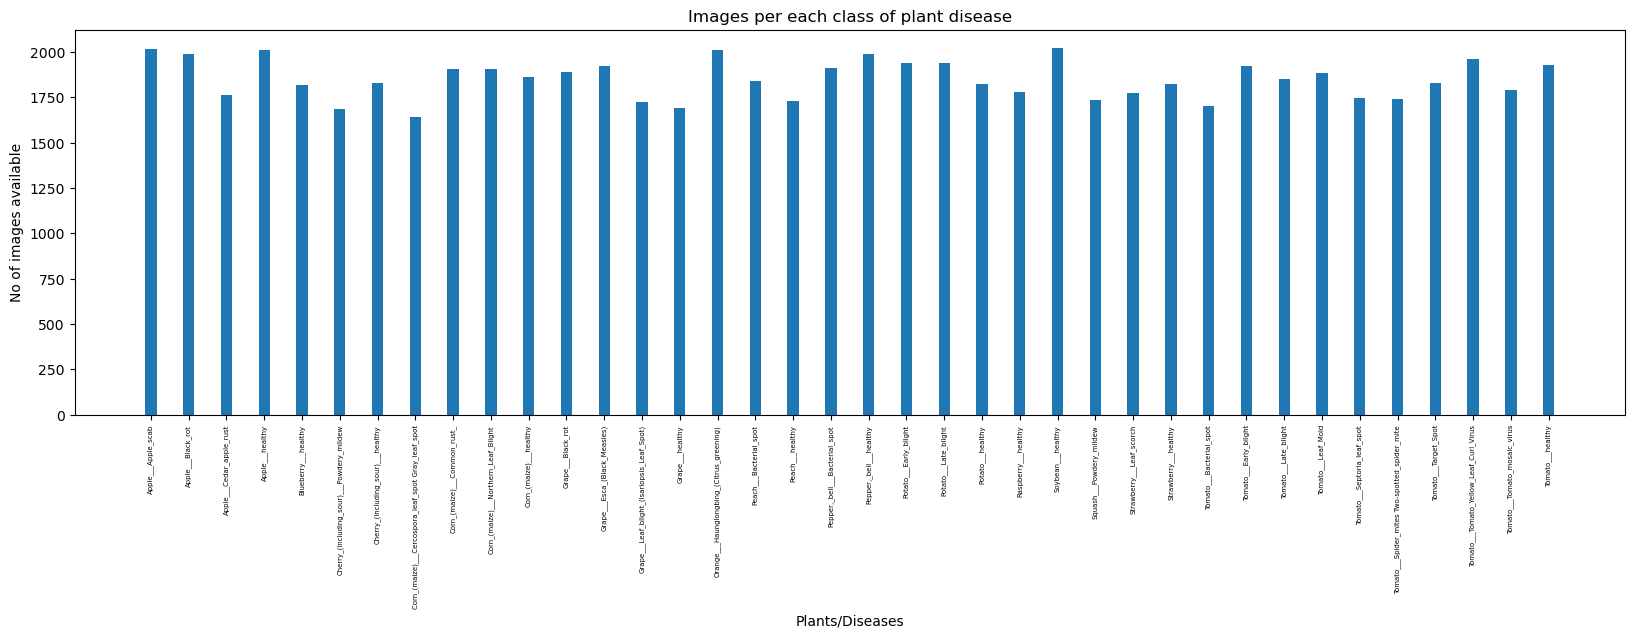

In [13]:
index = [n for n in range(38)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, class_names, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

# Show some image from dataset

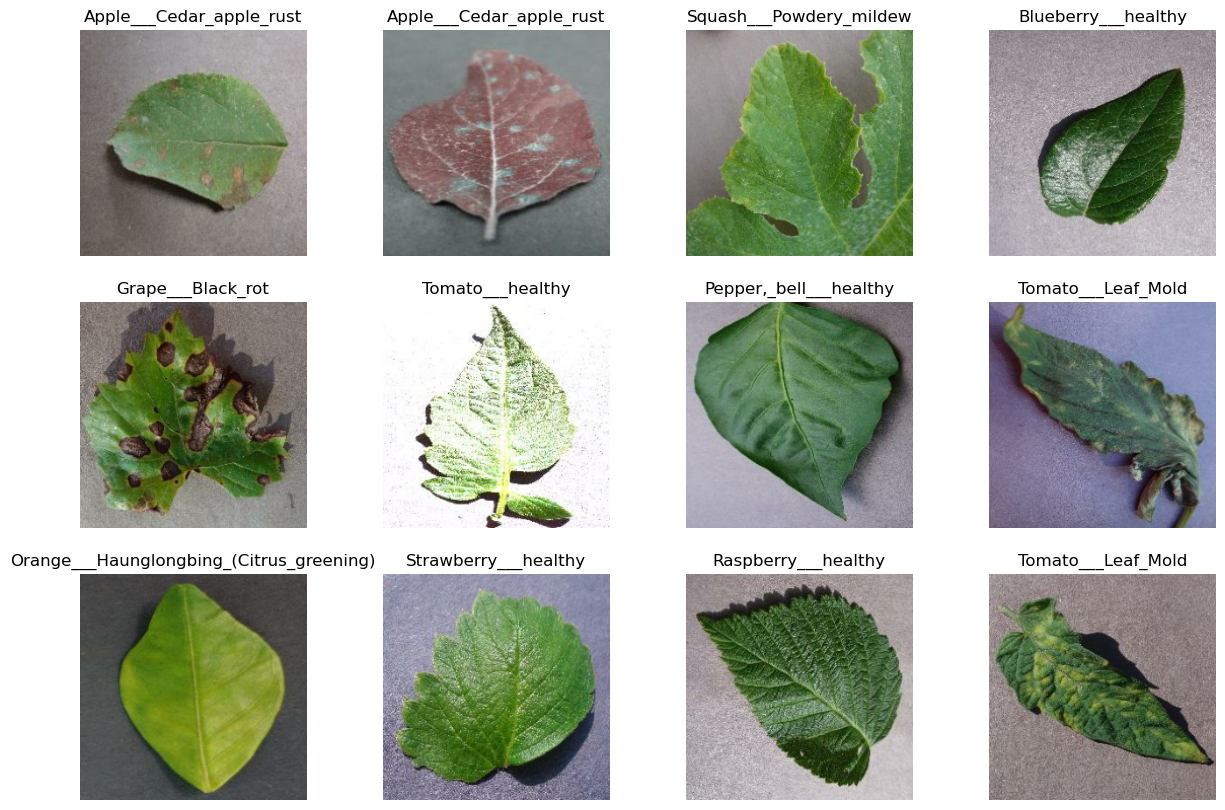

In [14]:
plt.figure(figsize=(15,10))
for image_batch,labels_batch in train_data.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

# **Image Processing**

## Image Acquisition

In [15]:
directory="../input/new-plant-diseases-dataset/test/test"
files = [os.path.join(directory,p) for p in sorted(os.listdir(directory))]
print(len(files))

33


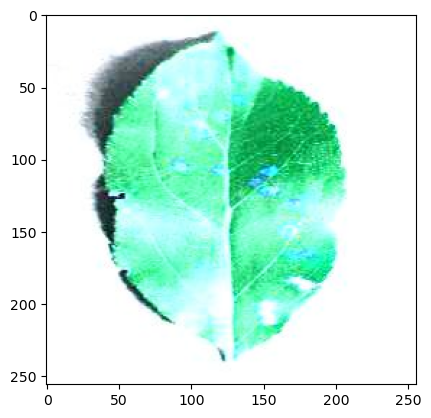

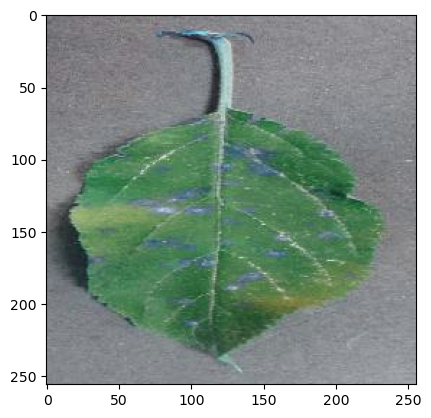

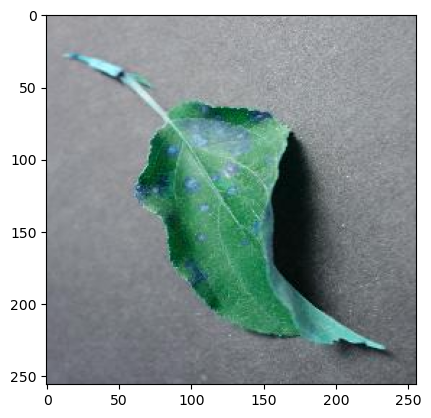

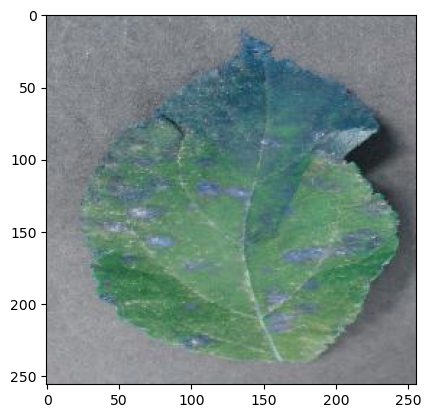

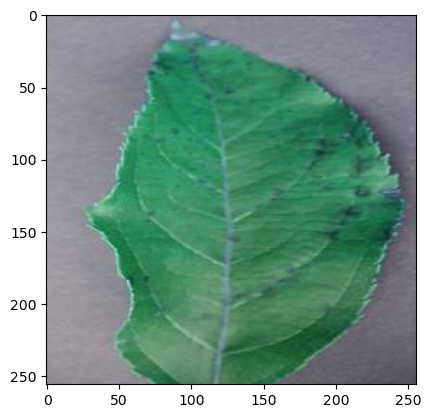

In [16]:
for i in range(5):
    img=cv2.imread(files[i])
    plt.imshow(img)
    plt.show()

## Color Image Processing

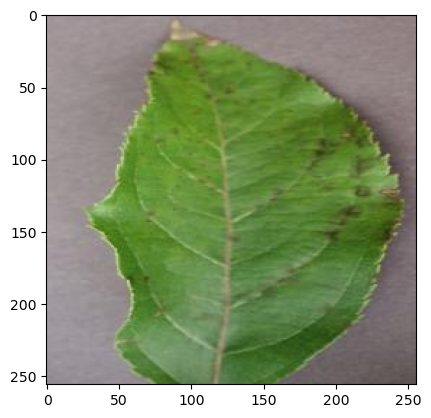

In [17]:
cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(cvt)
plt.show()

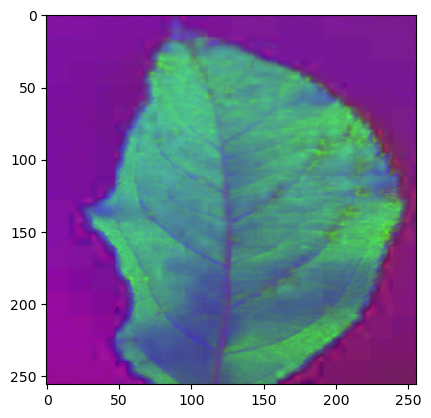

In [18]:
hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
plt.imshow(hsv_img)
plt.show()

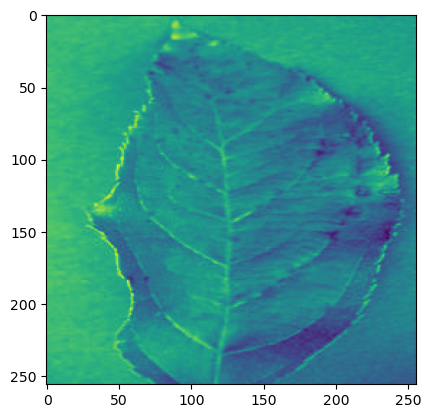

In [19]:
gray_image = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image)
plt.show()

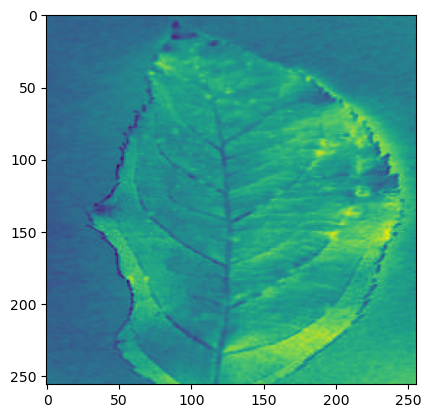

In [20]:
inverted_image = cv2.bitwise_not(gray_image)
plt.imshow(inverted_image)
plt.show()

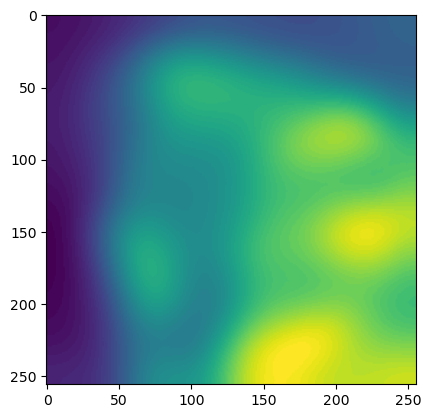

In [21]:
blurred = cv2.GaussianBlur(inverted_image, (111,111),0)
plt.imshow(blurred)
plt.show()

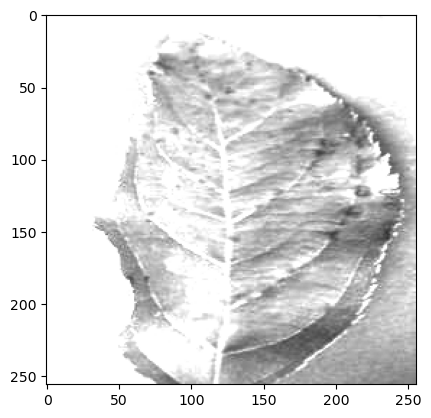

In [22]:
sketch_image=cv2.divide(gray_image,inverted_image, scale=256.0)
pencil_sketch=cv2.cvtColor(sketch_image, cv2.COLOR_BGR2RGB)
plt.imshow(pencil_sketch)
#plt.axis('off')
plt.show()

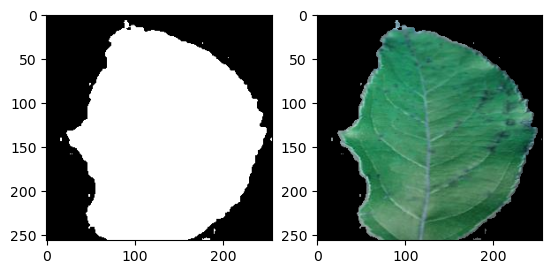

In [23]:
lower_green = np.array([25,0,20])
upper_green = np.array([100,255,255])
mask = cv2.inRange(hsv_img, lower_green, upper_green)
result = cv2.bitwise_and(img, img, mask=mask)
plt.subplot(1, 2, 1)
plt.imshow(mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(result)
plt.show()

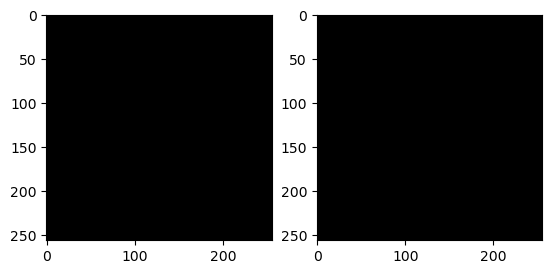

In [24]:
lower_brown = np.array([10,0,10])
upper_brown = np.array([30,255,255])
disease_mask = cv2.inRange(hsv_img, lower_brown, upper_brown)
disease_result = cv2.bitwise_and(img, img, mask=disease_mask)
plt.subplot(1, 2, 1)
plt.imshow(disease_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(disease_result)
plt.show()

## Image Enhancement

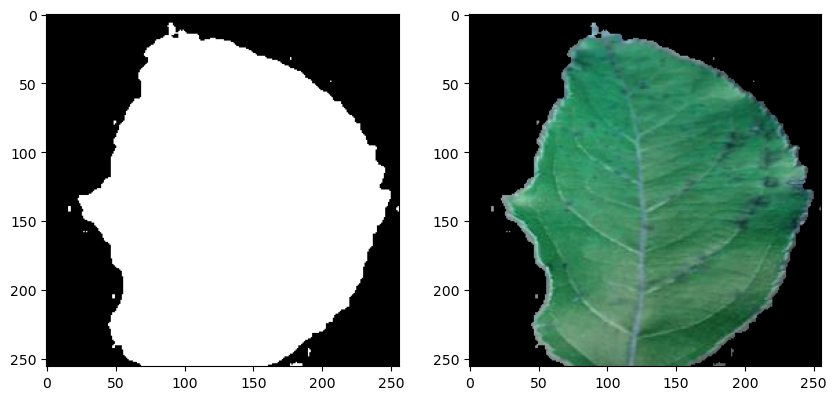

In [25]:
final_mask = mask + disease_mask
final_result = cv2.bitwise_and(img, img, mask=final_mask)
plt.figure(figsize=(10,10))
plt.subplot(1, 2, 1)
plt.imshow(final_mask, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(final_result)
plt.show()

## Image Restoration

In [26]:
# Noise Image

def noise(img,snr):
    h=img.shape[0]
    w=img.shape[1]
    img1=img.copy()
    sp=h*w
    NP=int(sp*(1-snr))
    for i in range (NP):
        randx=np.random.randint(1,h-1)
        randy=np.random.randint(1,w-1)
        if np.random.random()<=0.5:
            img1[randx,randy]=0
        else:
            img1[randx,randy]=255
    return img1

In [27]:
img_noise = noise(img, 0.6)

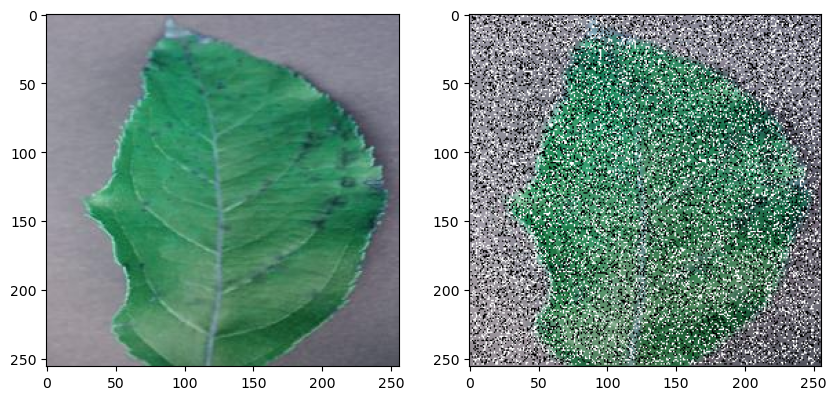

In [28]:
# plotting image - Image Noise

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(img_noise,cmap="gray")
plt.show()

In [29]:
median = cv2.medianBlur(img_noise, 5)

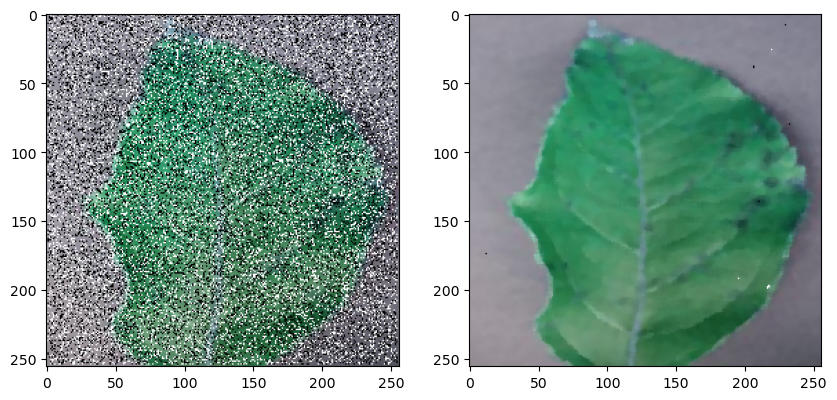

In [30]:
# plotting image - Median Filter

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(img_noise,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(median,cmap="gray")
plt.show()

In [31]:
img_gauss = cv2.GaussianBlur(img_noise, (5,5),0)

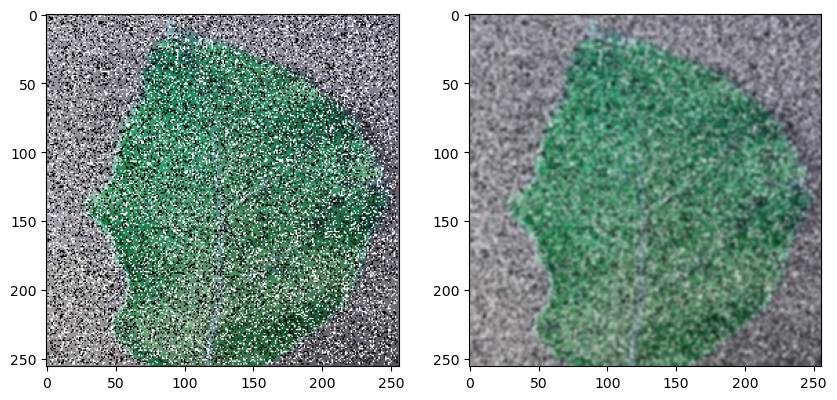

In [32]:
# plotting image - Gaussian Filter

plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(img_noise,cmap="gray")
plt.subplot(1,2,2)
plt.imshow(img_gauss,cmap="gray")
plt.show()

Rotat

## Image Compression

In [33]:
BGRImage = cv2.resize(img, (100, 100))
YCrCbImage = cv2.cvtColor(BGRImage, cv2.COLOR_BGR2YCR_CB)
Y, Cb, Cr = YCrCbImage[:,:,0], YCrCbImage[:,:,1], YCrCbImage[:,:,2]
Y = np.array(Y).astype(np.int16)
Cb = np.array(Cb).astype(np.int16)
Cr = np.array(Cr).astype(np.int16)
Y, Cb, Cr = Y - 128, Cb - 128, Cr - 128
print(img.shape)
print(BGRImage.shape)

(256, 256, 3)
(100, 100, 3)


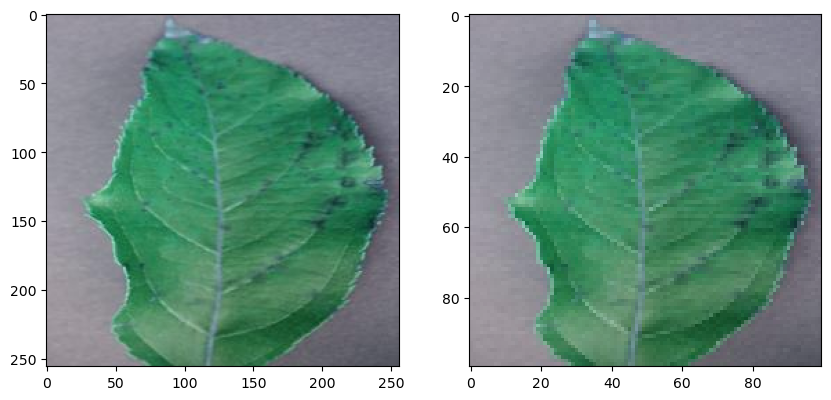

In [34]:
plt.figure(figsize=(10, 10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(BGRImage)
plt.show()

# Image segmentation

## 1. Image Segmentation using K-means

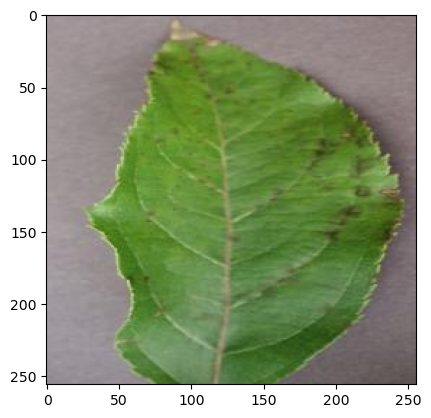

In [35]:
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [36]:
#Preprocessing the Image
twoDimage = img.reshape((-1,3))
twoDimage = np.float32(twoDimage)

In [37]:
#Defining Parameters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
attempts=10

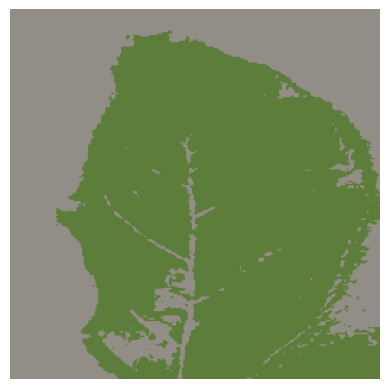

In [38]:
#Applying K-Means for Image Segmentation
ret,label,center=cv2.kmeans(twoDimage,K,None,criteria,attempts,cv2.KMEANS_PP_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))

plt.axis('off')
plt.imshow(result_image)

## 2. Image Segmentation using Contour Detection

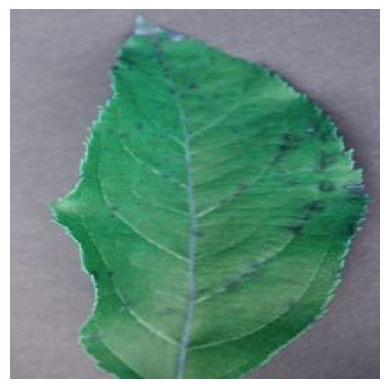

In [39]:

img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img,(256,256))

plt.axis('off');
plt.imshow(img)

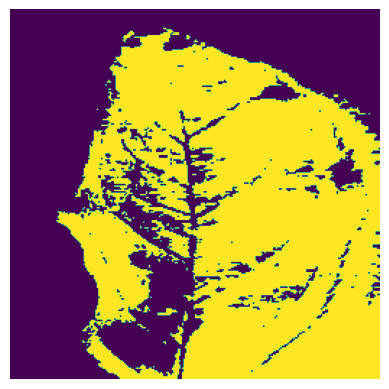

In [40]:
#Applying Image Thresholding
gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
_,thresh = cv2.threshold(gray, np.mean(gray), 255, cv2.THRESH_BINARY_INV)

plt.axis('off')
plt.imshow(thresh)

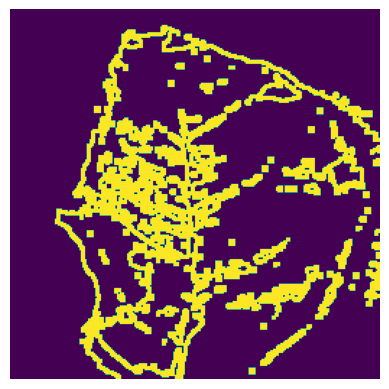

In [41]:
#Detecting Edges
edges = cv2.dilate(cv2.Canny(thresh,0,255),None)

plt.axis('off')
plt.imshow(edges)
edges = cv2.dilate(cv2.Canny(thresh,0,255),None)

plt.axis('off')
plt.imshow(edges)

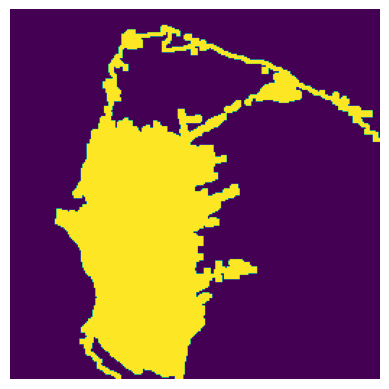

In [42]:
#Detecting Contours To Create Mask
cnt = sorted(cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2], key=cv2.contourArea)[-1]
mask = np.zeros((256,256), np.uint8)
masked = cv2.drawContours(mask, [cnt],-1, 255, -1)

plt.axis('off')
plt.imshow(masked)

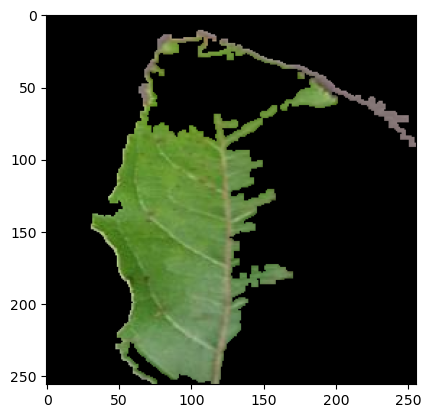

In [43]:
#Segmenting the Regions
dst = cv2.bitwise_and(img, img, mask=mask)
segmented = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
plt.imshow(segmented)

## 3. Image Segmentation using Color Masking

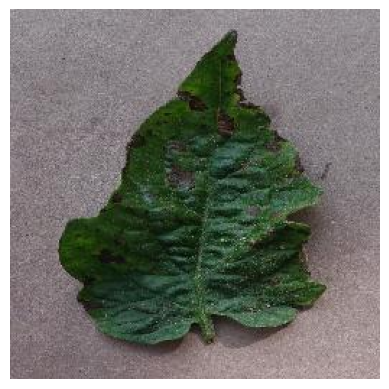

In [44]:
from skimage.filters import threshold_otsu
img2=cv2.imread('../input/new-plant-diseases-dataset/test/test/TomatoEarlyBlight3.JPG')
img = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)

plt.axis('off')
plt.imshow(img)

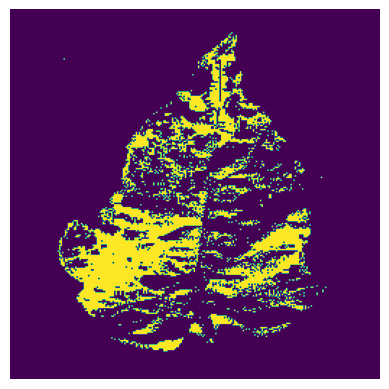

In [45]:
#Create Mask by Detecting Color
low = np.array([0, 0, 0])
high = np.array([215, 51, 51])

mask = cv2.inRange(img, low, high)

plt.axis('off')
plt.imshow(mask)

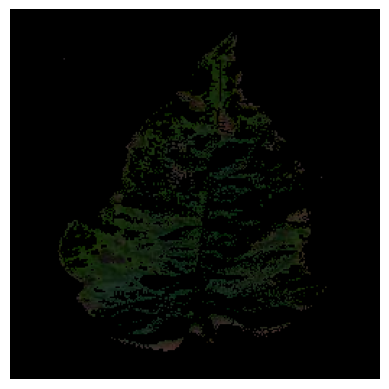

In [46]:
#Apply the Mask
result = cv2.bitwise_and(img, img, mask=mask)

plt.axis('off')
plt.imshow(result)

# Create model using Transfer Learning

# VGG16 for 20 Epochs

In [7]:
# Transfer learning VGG-16

pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[224,224, 3])
pretrained_model.trainable=False
vgg16_model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(38, activation='softmax')
])

58889256/58889256 [==============================] - 3s 0us/step


In [8]:
for layer in vgg16_model.layers:
  print(layer)

In [9]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 38)                953382    
                                                                 
Total params: 15,668,070
Trainable params: 953,382
Non-trainable params: 14,714,688
_________________________________________________________________


The sequential model uses a pre-trained VGG16 model to extract features from the input data. The VGG16 layer produces a feature map with a shape of (None, 7, 7, 512). The flatten layer converts this 2D feature map into a 1D vector. Finally, the dense layer with 38 units maps the features to the output classes. The model has a total of 15,668,070 parameters, with 953,382 of them being trainable.

In [52]:
import functools
top5_acc = functools.partial(tf.keras.metrics.SparseTopKCategoricalAccuracy())

vgg16_model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [53]:
history = vgg16_model.fit(train_ds, epochs=20,
                    validation_data=val_ds,steps_per_epoch=len(train_ds)/50,
  validation_steps=len(val_ds)/50
                         )

Epoch 1/20
11/11 [==============================] - 442s 41s/step - loss: 3.1832 - accuracy: 0.2635 - val_loss: 1.7906 - val_accuracy: 0.5104
Epoch 2/20
11/11 [==============================] - 440s 41s/step - loss: 1.3932 - accuracy: 0.5909 - val_loss: 1.0188 - val_accuracy: 0.7057
Epoch 3/20
11/11 [==============================] - 438s 41s/step - loss: 0.9088 - accuracy: 0.7216 - val_loss: 0.7684 - val_accuracy: 0.7656
Epoch 4/20
11/11 [==============================] - 438s 41s/step - loss: 0.7010 - accuracy: 0.7898 - val_loss: 0.5903 - val_accuracy: 0.8203
Epoch 5/20
11/11 [==============================] - 436s 41s/step - loss: 0.6345 - accuracy: 0.8082 - val_loss: 0.5210 - val_accuracy: 0.8464
Epoch 6/20
11/11 [==============================] - 437s 41s/step - loss: 0.5560 - accuracy: 0.8295 - val_loss: 0.5094 - val_accuracy: 0.8568
Epoch 7/20
11/11 [==============================] - 436s 41s/step - loss: 0.5221 - accuracy: 0.8523 - val_loss: 0.4893 - val_accuracy: 0.8516
Epoch 

Observations:

The model was trained for 20 epochs using the provided datasets.
The training accuracy steadily increased from 26.4% to 91.5% over the epochs.
The validation accuracy also improved from 51.0% to 92.9%.
The loss decreased consistently for both training and validation sets.
The model achieved high accuracy and low loss, indicating good performance and effective learning.
The training time per epoch was approximately 7-7.5 minutes.
Overall, the model demonstrated successful learning and performed well in classifying the given data.

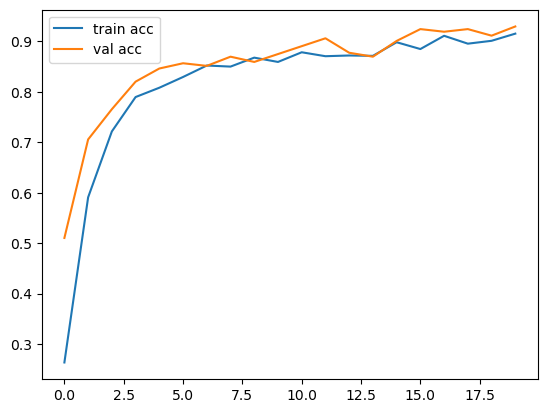

<Figure size 640x480 with 0 Axes>

In [54]:
#plot the accuracy
plt.plot(history.history['accuracy'], label='train acc') 
plt.plot(history.history['val_accuracy'], label='val acc') 
plt.legend() 
plt.show() 
plt.savefig('AccVal_acc')

The model is neither overfitting nor underfitting. It shows a consistent increase in both training and validation accuracy while decreasing the loss. This indicates a good fit for the data.

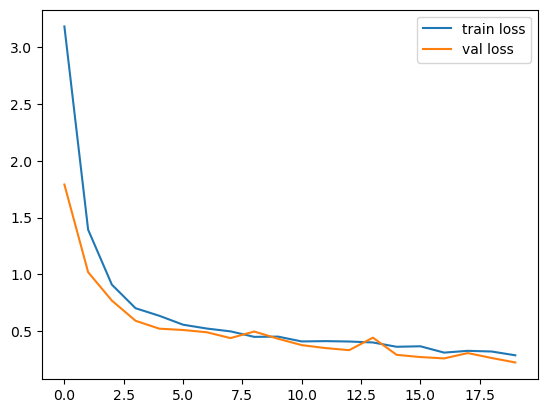

<Figure size 640x480 with 0 Axes>

In [55]:
#plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss') 
plt.legend() 
plt.show() 
plt.savefig('LossVal_loss')

In [58]:
# Load Model
from tensorflow.keras.models import load_model

vgg16_model.save('/kaggle/working/model1_vgg16.h5')

# VGG16 for 35 Epochs

In [49]:
# Transfer learning VGG-16

pretrained_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=[224,224, 3])
pretrained_model.trainable=False
vgg16_model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(38, activation='softmax')
])

58889256/58889256 [==============================] - 2s 0us/step


In [50]:
for layer in vgg16_model.layers:
  print(layer)

In [ ]:
pretrained_model.summary()

In [51]:
vgg16_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 38)                953382    
                                                                 
Total params: 15,668,070
Trainable params: 953,382
Non-trainable params: 14,714,688
_________________________________________________________________


In [52]:
import functools
top5_acc = functools.partial(tf.keras.metrics.SparseTopKCategoricalAccuracy())

vgg16_model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [54]:
history = vgg16_model.fit(train_ds, epochs=35,
                    validation_data=val_ds,steps_per_epoch=len(train_ds)/50,
  validation_steps=len(val_ds)/50
                         )

Epoch 1/30
11/11 [==============================] - 347s 32s/step - loss: 3.2472 - accuracy: 0.2706 - val_loss: 2.2057 - val_accuracy: 0.4089
Epoch 2/30
11/11 [==============================] - 339s 31s/step - loss: 1.5018 - accuracy: 0.6044 - val_loss: 1.0542 - val_accuracy: 0.6953
Epoch 3/30
11/11 [==============================] - 341s 32s/step - loss: 0.9476 - accuracy: 0.7330 - val_loss: 0.8230 - val_accuracy: 0.7526
Epoch 4/30
11/11 [==============================] - 338s 31s/step - loss: 0.7549 - accuracy: 0.7791 - val_loss: 0.7076 - val_accuracy: 0.7734
Epoch 5/30
11/11 [==============================] - 337s 31s/step - loss: 0.5978 - accuracy: 0.8295 - val_loss: 0.5480 - val_accuracy: 0.8490
Epoch 6/30
11/11 [==============================] - 339s 32s/step - loss: 0.5782 - accuracy: 0.8246 - val_loss: 0.5130 - val_accuracy: 0.8620
Epoch 7/30
11/11 [==============================] - 339s 31s/step - loss: 0.5129 - accuracy: 0.8473 - val_loss: 0.4596 - val_accuracy: 0.8672
Epoch 

Accuracy and Trend:

The model achieves a training accuracy of 90.91% and a validation accuracy of 91.93%.
The accuracy steadily improves over the epochs, indicating that the model is learning and improving its performance.
There is no significant gap between the training and validation accuracy, suggesting that the model is not overfitting to the training data.
The accuracy trend suggests that the model is effectively capturing the patterns and features in the data, leading to better predictions.

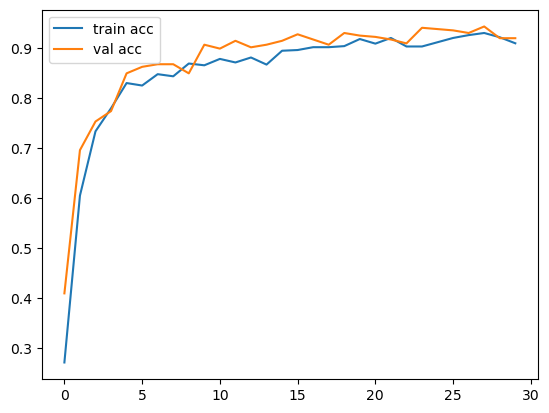

<Figure size 640x480 with 0 Axes>

In [55]:
#plot the accuracy
plt.plot(history.history['accuracy'], label='train acc') 
plt.plot(history.history['val_accuracy'], label='val acc') 
plt.legend() 
plt.show() 
plt.savefig('AccVal_acc')

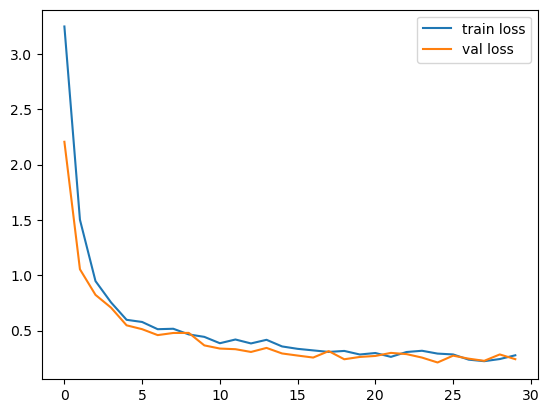

<Figure size 640x480 with 0 Axes>

In [56]:
#plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss') 
plt.legend() 
plt.show() 
plt.savefig('LossVal_loss')

In [58]:
# save it as a h5 file
from tensorflow.keras.models import load_model

vgg16_model.save('/kaggle/working/model2_vgg16.h5')

# Predict the model using validation dataset

In [ ]:
AccuracyVector = []
plt.figure(figsize=(15, 15))
for images, labels in val_ds.take(1):
    
    predictions =vgg16_model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
#     print(predlabel)
#     print(prdlbl)
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('\nPred: '+ predlabel[i]+"\n"+' actl:'+class_names[labels[i]] )
        #plt.title(f"Actual: {class_names[labels[i]]},\n Predicted: {predlabel[i]}.\n")
        plt.axis('off')
        plt.grid(True)

# Predict the model using training dataset

In [ ]:
AccuracyVector = []
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    predictions = vgg16_model.predict(images)
    predlabel = []
    prdlbl = []
    
    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('\nPredicted: '+ predlabel[i]+"\n"+' actual:'+class_names[labels[i]] )
        #plt.title(f"Actual: {class_names[labels[i]]},\n Predicted: {predlabel[i]}.\n")
        plt.axis('off')
        plt.grid(True)

In [58]:
test_path="../input/new-plant-diseases-dataset/test"
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
   test_path,
    seed=42,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

Found 33 files belonging to 1 classes.


In [59]:
class_names1 = test_ds.class_names
print(class_names1)
print("\nTotal disease classes are: {}".format(len(class_names1)))

['test']

Total disease classes are: 1


In [60]:
print(type(test_ds))

<class 'tensorflow.python.data.ops.batch_op._BatchDataset'>


In [ ]:
AccuracyVector = []
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    #print(labels)
    predictions = vgg16_model.predict(images)
    predlabel = []
    prdlbl = []
    #print(labels)

    for mem in predictions:
        predlabel.append(class_names[np.argmax(mem)])
        prdlbl.append(np.argmax(mem))
    #print(predlabel)
    #print(prdlbl)
    
    AccuracyVector = np.array(prdlbl) == labels
    for i in range(9):
        ax = plt.subplot(3,3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title('\nPred: '+ predlabel[i])      #+"\n"+' actl:'+class_names1[labels[i]] )
        #plt.title(f"Actual: {class_names[labels[i]]},\n Predicted: {predlabel[i]}.\n")
        plt.axis('off')
        plt.grid(True)

In [75]:
Classes = ["Apple___Apple_scab", 
           "Apple___Black_rot", 
           "Apple___Cedar_apple_rust", 
           "Apple___healthy", 
           "Blueberry___healthy", 
           "Cherry_(including_sour)___Powdery_mildew", 
           "Cherry_(including_sour)___healthy",
           "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot", 
           "Corn_(maize)___Common_rust",  
           "Corn_(maize)___Northern_Leaf_Blight", 
           "Corn_(maize)___healthy",
           "Grape___Black_rot", 
           "Grape___Esca_(Black_Measles)", 
           "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",  
           "Grape___healthy",
           "Orange___Haunglongbing_(Citrus_greening)", 
           "Peach___Bacterial_spot", 
           "Peach___healthy", 
           "Pepper__bell___Bacterial_spot", 
           "Pepper__bell___healthy", 
           "Potato___Early_blight",
           "Potato___Late_blight",
           "Potato___healthy",
           "Raspberry___healthy", 
           "Soybean___healthy", 
           "Squash___Powdery_mildew", 
           "Strawberry___Leaf_scorch",
           "Strawberry___healthy",
           "Tomato___Bacterial_spot",
           "Tomato___Early_blight",
           "Tomato___Late_blight",
           "Tomato___Leaf_Mold",
           "Tomato___Septoria_leaf_spot",
           "Tomato___Spider_mites Two-spotted_spider_mite",
           "Tomato___Target_Spot",
           "Tomato___Tomato_Yellow_Leaf_Curl_Virus" ,
           "Tomato___Tomato_mosaic_virus",
           "Tomato___healthy",
           ]

# Single image prediction

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np
directory="../input/new-plant-diseases-dataset/test/test/TomatoEarlyBlight1.JPG"
#files = [os.path.join(directory,p) for p in sorted(os.listdir(directory))] 

#for i in range(0,5):
from keras.utils import load_img
image_path = directory
new_img = image.load_img(image_path, target_size=(224, 224))
img = image.img_to_array(new_img)
img = np.expand_dims(img, axis=0)
img = img/255
prediction = vgg16_model.predict(img)
    #print(prediction)
probabilty = prediction.flatten()
    #print(probabilty)
max_prob = probabilty.max()
index=prediction.argmax(axis=-1)[0]
    #print(index)
class_name = Classes[index]
    #print(class_name)
    #ploting image with predicted class name        
plt.figure(figsize = (4,4))
    #ax = plt.subplot(3,3, i + 1)
plt.imshow(new_img)
plt.axis('off')
plt.title(class_name+" "+ str(max_prob)[0:4]+"%")
plt.show()

In [98]:
rescale = Rescaling(scale=1.0/255)
test_gen  = val_data.map(lambda image,label:(rescale(image),label))


In [ ]:
labels = []
predictions = []
for x,y in test_gen:
    labels.append(list(y.numpy()))
    predictions.append(tf.argmax(vgg16_model.predict(x),1).numpy())

In [ ]:
predictions = list(itertools.chain.from_iterable(predictions))
labels = list(itertools.chain.from_iterable(labels))

# Confusion Matrix

In [ ]:
plt.figure(figsize= (20,5))
cm = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=list(range(1,39)))
fig, ax = plt.subplots(figsize=(15,15))
disp.plot(ax=ax,colorbar= False,cmap = 'YlGnBu')
plt.title("Confusion Matrix")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# <center>**Thank you**</center>